In [1]:
import pandas as pd
import csv
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
import statsmodels.api as sm
from pylab import rcParams
%matplotlib inline

import itertools as it
from datetime import datetime

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric, plot_forecast_component
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR
from fbprophet import Prophet

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math


import warnings
warnings.filterwarnings('ignore')

import acquire
import prepare

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Acquire Fitbit data

In [2]:
df = acquire.merge_dataframes()

In [3]:
#df.to_csv('/Users/rachelreuter/ds-methodologies/time_series/project_explore/project_data.csv')

In [4]:
df.shape

(225, 10)

In [5]:
df.head()

,date,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
1,2018-04-26,"2,635","2,931",1.38,2,"1,347",93,0,0,566
2,2018-04-27,"3,649","9,971",4.7,19,"1,158",219,46,17,"1,752"
3,2018-04-28,"3,379","3,521",1.66,2,702,155,22,11,"1,124"
4,2018-04-29,"2,851","1,639",0.77,0,891,122,0,0,602
5,2018-04-30,"2,825","1,323",0.62,0,880,104,0,0,540


In [6]:
def missing_values_col(df):
    """
    Write or use a previously written function to return the
    total missing values and the percent missing values by column.
    """
    null_count = df.isnull().sum()
    null_percentage = (null_count / df.shape[0]) * 100
    empty_count = pd.Series(((df == ' ') | (df == '')).sum())
    empty_percentage = (empty_count / df.shape[0]) * 100
    nan_count = pd.Series(((df == 'nan') | (df == 'NaN')).sum())
    nan_percentage = (nan_count / df.shape[0]) * 100
    return pd.DataFrame({'num_missing': null_count, 'missing_percentage': null_percentage,
                         'num_empty': empty_count, 'empty_percentage': empty_percentage,
                         'nan_count': nan_count, 'nan_percentage': nan_percentage})

missing_values_col(df)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
date,0,0.00,0,0.00,0,0.00
calories_burned,0,0.00,0,0.00,0,0.00
steps,0,0.00,0,0.00,0,0.00
distance,0,0.00,0,0.00,0,0.00
floors,0,0.00,0,0.00,0,0.00
minutes_sedentary,0,0.00,0,0.00,0,0.00
minutes_lightly_active,0,0.00,0,0.00,0,0.00
minutes_fairly_active,0,0.00,0,0.00,0,0.00
minutes_very_active,0,0.00,0,0.00,0,0.00
activity_calories,0,0.00,0,0.00,0,0.00


# Prepare

In [7]:
df = prepare.update_dtypes(df)

In [8]:
df.dtypes

calories_burned             int64
steps                       int64
distance                  float64
 floors                     int64
minutes_sedentary           int64
minutes_lightly_active      int64
minutes_fairly_active       int64
minutes_very_active         int64
activity_calories           int64
dtype: object

# Exploration

In [9]:
df[df.steps <= 500].shape

(17, 9)

In [10]:
#df[df.minutes_sedentary >= 1440]

In [11]:
#df.sort_values('steps',ascending=True)

In [12]:
df.describe()

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
count,225.00,225.00,225.00,225.00,225.00,225.00,225.00,225.00,225.00
mean,"3,401.91","8,536.19",4.05,12.59,809.52,188.24,14.92,33.87,"1,484.55"
std,632.43,"5,255.75",2.51,25.84,243.23,75.17,15.36,37.20,747.80
min,799.00,0.00,0.00,0.00,28.00,0.00,0.00,0.00,0.00
25%,"3,069.00","4,714.00",2.22,2.00,654.00,158.00,3.00,2.00,"1,062.00"
50%,"3,385.00","7,806.00",3.68,7.00,750.00,203.00,11.00,15.00,"1,481.00"
75%,"3,765.00","12,380.00",5.90,13.00,877.00,236.00,21.00,63.00,"1,962.00"
max,"5,199.00","25,512.00",12.00,195.00,"1,440.00",349.00,78.00,154.00,"3,596.00"


In [13]:
df.shape

(225, 9)

In [14]:
df['min_active'] = df.minutes_lightly_active + df.minutes_fairly_active + df.minutes_very_active

In [15]:
df.tail()

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,min_active
date,,,,,,,,,,
2018-12-02,3957,13257,6.23,195,725,265,13,70,2305,348
2018-12-03,3660,12915,6.12,6,782,219,40,51,1993,310
2018-12-04,3384,13763,6.49,13,608,199,11,67,1663,277
2018-12-05,3670,13865,6.52,12,739,200,12,69,1968,281
2018-12-06,3669,14774,6.96,9,647,198,4,78,1962,280


In [16]:
# activity_daily_ratio = df.min_active / 1440
# activity_daily_ratio

In [17]:
# activity_vs_sed_ratio = df.min_active / df.minutes_sedentary
# activity_vs_sed_ratio

In [18]:
# act_vs_all_cals = df.activity_calories / df.calories_burned
# act_vs_all_cals

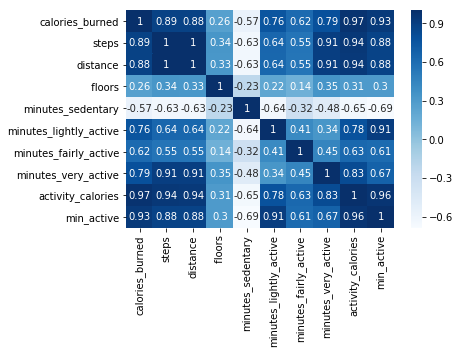

In [19]:
sns.heatmap(df.corr(), cmap='Blues', annot=True)

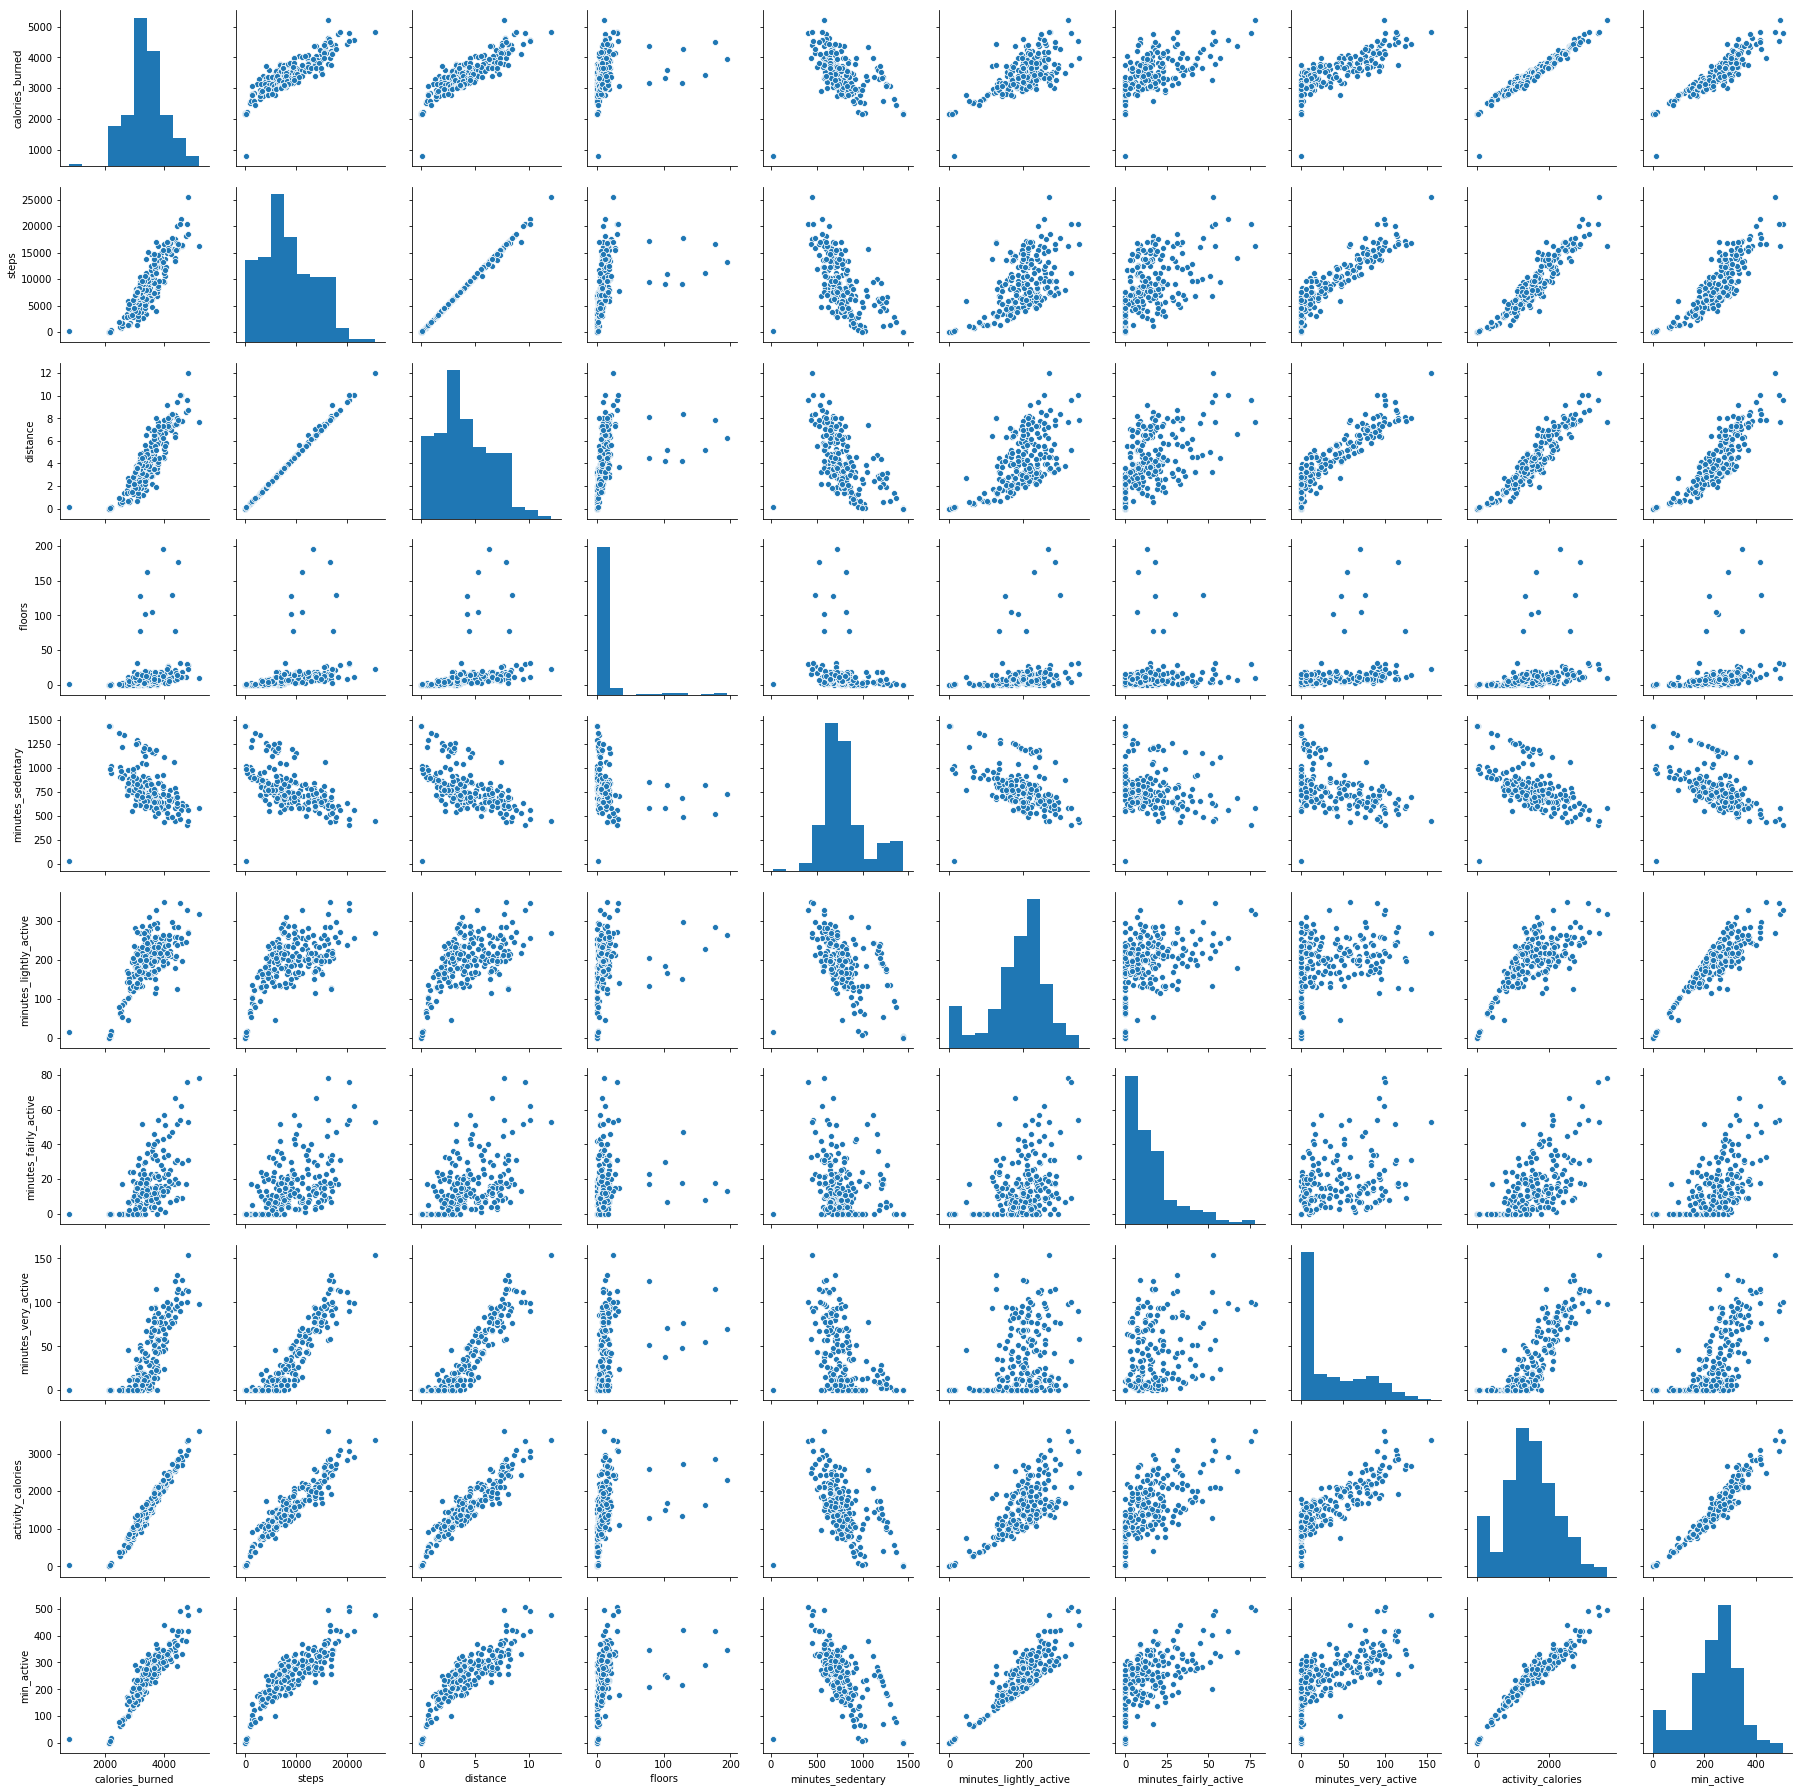

In [20]:
sns.pairplot(df)

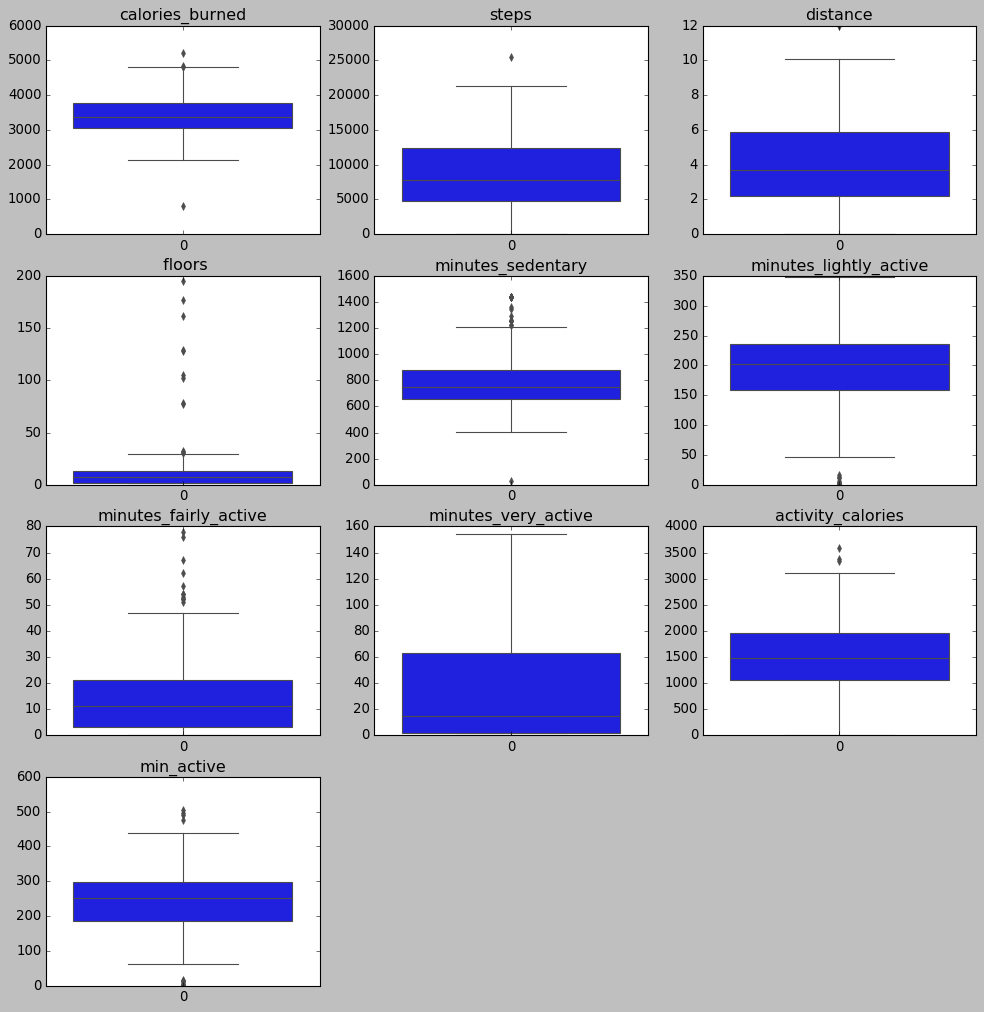

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('classic')


plt.figure(figsize=(15, 15))

for i, col in enumerate(['calories_burned', 'steps', 'distance', ' floors', 'minutes_sedentary','minutes_lightly_active', 'minutes_fairly_active', 'minutes_very_active','activity_calories','min_active']):
    plot_number = i + 1 # i starts at 0, but plot nos should start at 1
    series = df[col]
    plt.subplot(4, 3, plot_number)
    plt.title(col)
    sns.boxplot(data=series)

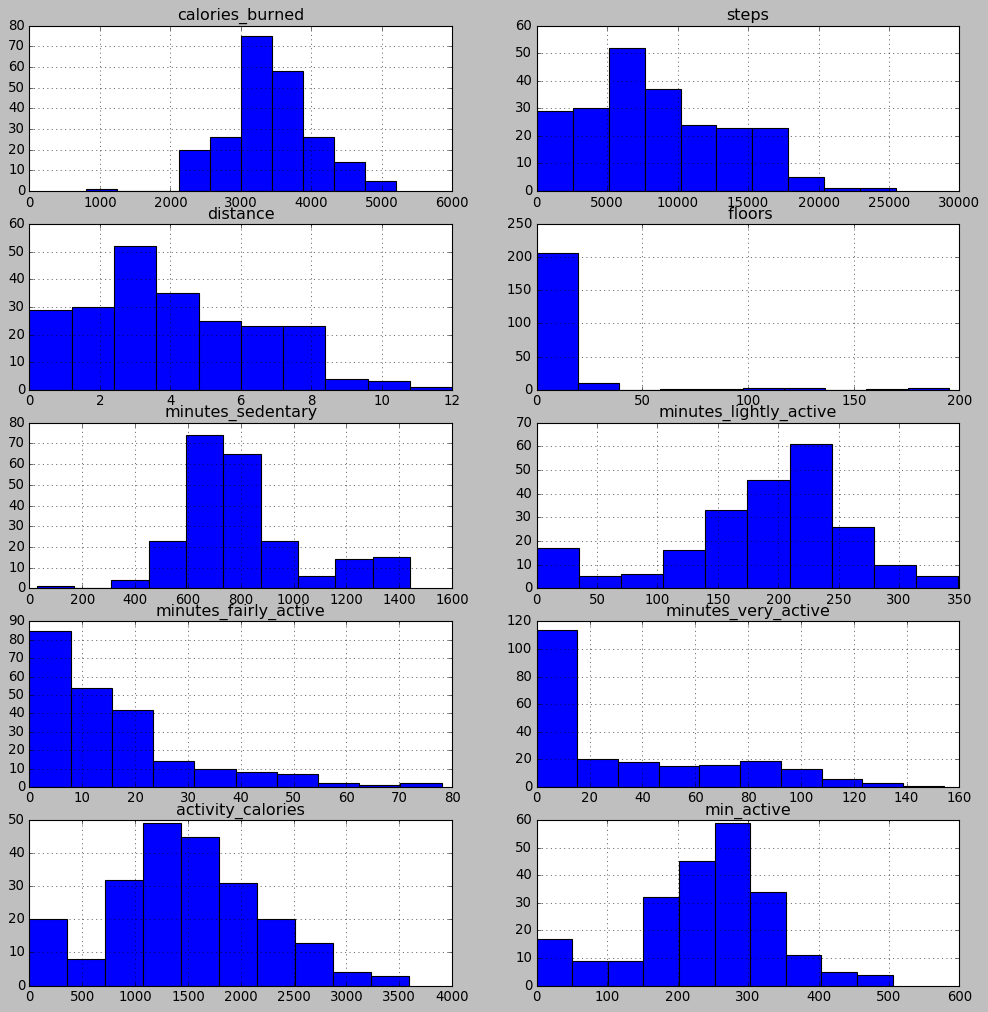

In [22]:
plt.figure(figsize=(15, 15))
for i, col in enumerate(['calories_burned', 'steps', 'distance', ' floors', 'minutes_sedentary','minutes_lightly_active', 'minutes_fairly_active', 'minutes_very_active','activity_calories','min_active']):
    plot_number = i + 1  # i starts at 0, but plot nos should start at 1
    series = df[col]
    plt.subplot(5, 2, plot_number)
    plt.title(col)
    series.hist(density=False, cumulative=False, log=False)

In [23]:
df.isna().sum()

calories_burned           0
steps                     0
distance                  0
 floors                   0
minutes_sedentary         0
minutes_lightly_active    0
minutes_fairly_active     0
minutes_very_active       0
activity_calories         0
min_active                0
dtype: int64

In [24]:
train = df[:'2018-10-31']
test = df['2018-11-01':]
print('\nTRAIN:')
print(train.nunique())
print('\nTEST:')
print(test.nunique())


TRAIN:
calories_burned           172
steps                     177
distance                  158
 floors                    30
minutes_sedentary         153
minutes_lightly_active    119
minutes_fairly_active      49
minutes_very_active        75
activity_calories         172
min_active                141
dtype: int64

TEST:
calories_burned           36
steps                     36
distance                  35
 floors                   24
minutes_sedentary         34
minutes_lightly_active    30
minutes_fairly_active     23
minutes_very_active       29
activity_calories         36
min_active                35
dtype: int64


In [25]:
print('\ntrain shape:')
train.shape


train shape:


(189, 10)

In [26]:
print('\ntest shape:')
test.shape


test shape:


(36, 10)

In [27]:
cals = train.resample('D').calories_burned.mean()

In [28]:
cals.head()

date
2018-04-26    2635
2018-04-27    3649
2018-04-28    3379
2018-04-29    2851
2018-04-30    2825
Freq: D, Name: calories_burned, dtype: int64

In [29]:
steps_df = train.resample('D').steps.mean()

Text(0.5, 1.0, 'Daily Steps')

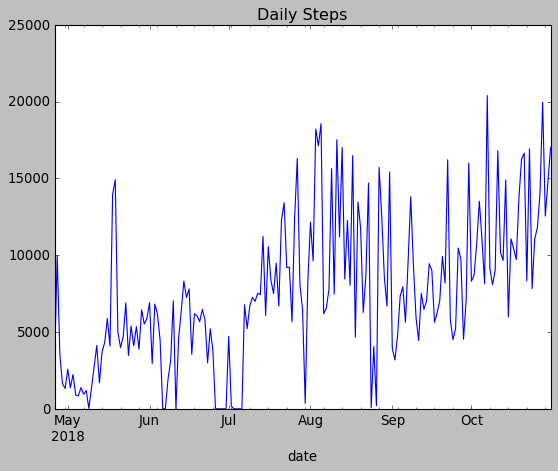

In [30]:
steps_df.plot()
plt.title('Daily Steps')

Text(0.5, 1.0, 'Daily Calories Burned')

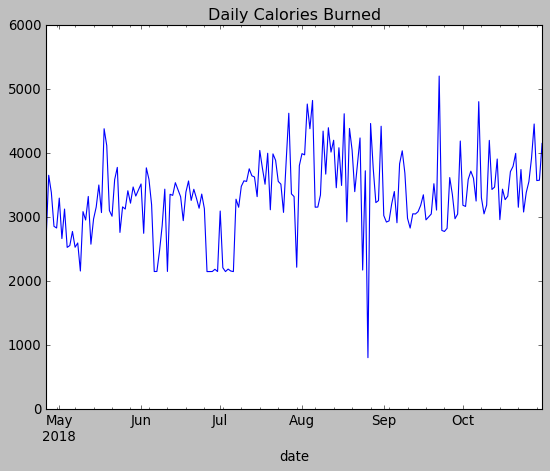

In [31]:
cals.plot()
plt.title('Daily Calories Burned')

Text(0.5, 1.0, 'Weekly Avg Calories Burned')

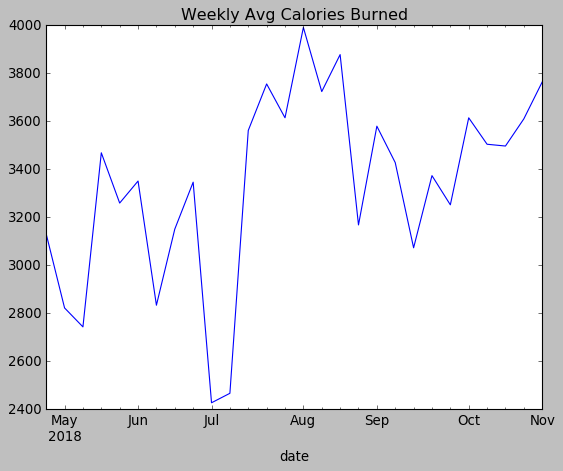

In [32]:
cals.resample('W').mean().plot()
plt.title('Weekly Avg Calories Burned')

Text(0.5, 1.0, 'Monthly Avg Calories Burned')

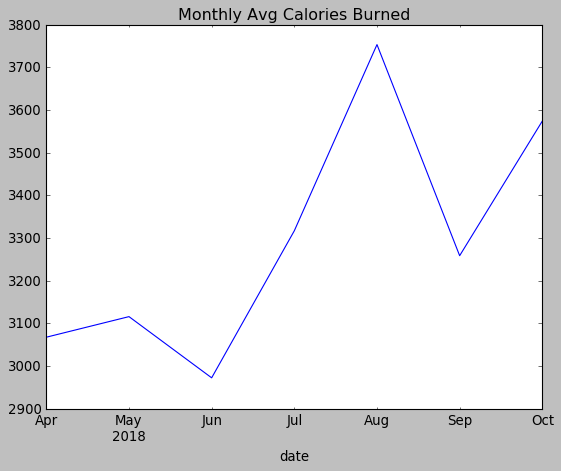

In [33]:
cals.resample('MS').mean().plot()
plt.title('Monthly Avg Calories Burned')

Text(0.5, 1.0, 'Rolling Five-Day Avg Calories Burned')

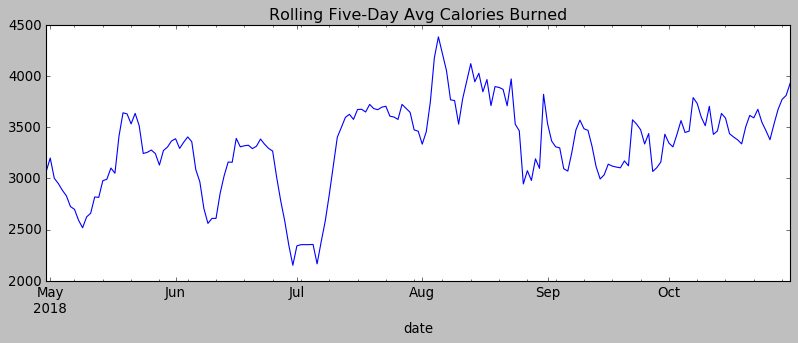

In [34]:
cals.rolling(5).mean().plot(figsize=(12,4))
plt.title('Rolling Five-Day Avg Calories Burned')

Text(0.5, 1.0, 'Ten-Period Difference in Calories Burned')

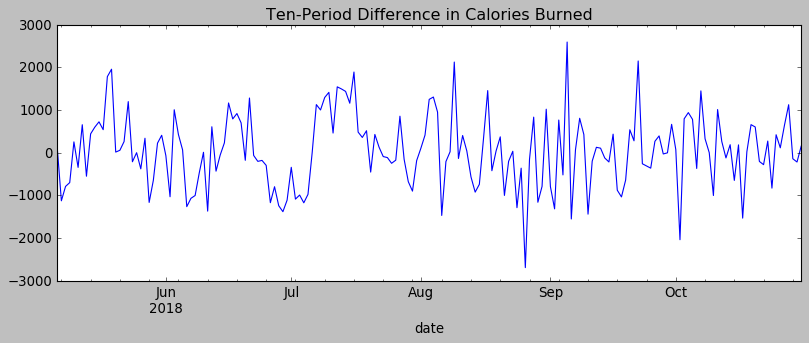

In [35]:
cals.diff(periods=10).plot(figsize=(12,4))
plt.title('Ten-Period Difference in Calories Burned')

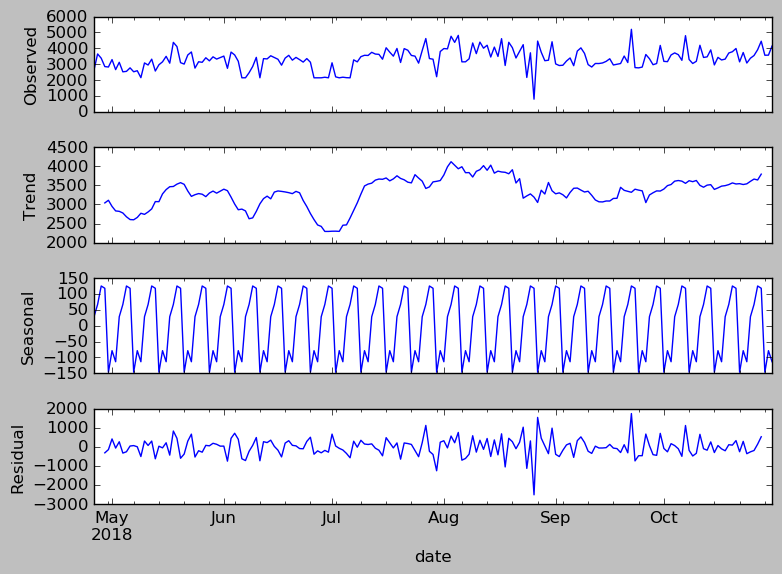

In [36]:
decomposition = sm.tsa.seasonal_decompose(cals, model='additive')
fig = decomposition.plot()
#figsize=(10,10)
fig.set_dpi(100)
plt.show()

### Plot the measure (t) on the x-axis against the calories_burned at the previous time step (t-1)

Text(0.5, 1.0, 'Calories Burned vs Calories Burned at Prev. Time Step')

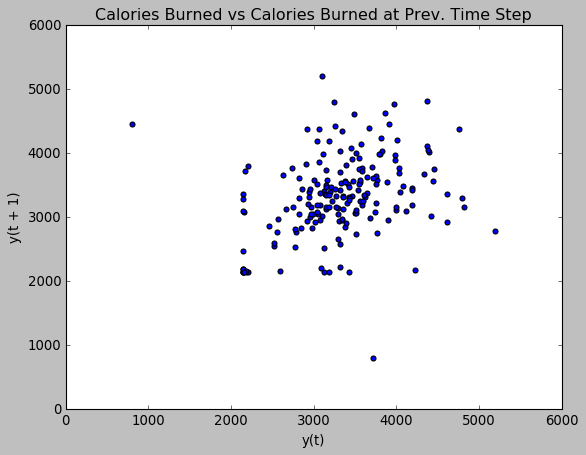

In [37]:
pd.plotting.lag_plot(cals)
plt.title('Calories Burned vs Calories Burned at Prev. Time Step')

In [38]:
df_corr = pd.concat([cals.shift(1),cals], axis=1)
df_corr.columns = ['t-1','t+1']
result = df_corr.corr()
print(result)

                     t-1                  t+1
t-1                 1.00                 0.31
t+1                 0.31                 1.00


## Prophet

In [39]:
df1 = df[df['calories_burned']>=1]
df1 = df1.reset_index()

In [40]:
df1['y'] = df1.calories_burned
df1['ds'] = pd.to_datetime(df1.date)
df1 = df1.groupby(['ds'])['y'].sum().reset_index()

## Model

### PROPHET using 'calories_burned' field.

In [41]:
df1['cap'] = 5500
df1['floor'] = 100
m = Prophet(daily_seasonality=True, growth='logistic', changepoint_range=0.9,yearly_seasonality=True)
m.fit(df1)

### Create a "future" dataframe

In [42]:
future = m.make_future_dataframe(periods=22)
future['cap'] = 5500
future['floor'] = 100

### Predict
- Call predict to make a prediction and store it in the forecast dataframe.
- In that df you will see the the predictions as well as the lower and upper boundaries of the uncertainty interval.

In [43]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(22)

forecast_cal_burn = forecast[['ds','yhat']]
forecast_cal_burn

,ds,yhat
0,2018-04-26,"3,065.28"
1,2018-04-27,"3,063.46"
2,2018-04-28,"3,105.66"
3,2018-04-29,"3,061.83"
4,2018-04-30,"2,711.41"
5,2018-05-01,"2,745.35"
6,2018-05-02,"2,689.60"
7,2018-05-03,"2,845.21"
8,2018-05-04,"2,892.45"
9,2018-05-05,"2,985.24"


#Prophet-Calories_burned done

### Second Prophet model on "steps" field

In [44]:
df2 = df[df['steps']>=1]
df2 = df2.reset_index()

In [45]:
df2['y'] = df2.steps
df2['ds'] = pd.to_datetime(df2.date)
df2 = df2.groupby(['ds'])['y'].sum().reset_index()

## Model

### PROPHET using 'steps' field.

In [46]:
df2['cap'] = 25000
df2['floor'] = 100
m = Prophet(daily_seasonality=True, growth='logistic', changepoint_range=0.9,yearly_seasonality=True)
m.fit(df2)

### Create a "future" dataframe

In [47]:
future = m.make_future_dataframe(periods=22)
future['cap'] = 25000
future['floor'] = 100

### Predict
- Call predict to make a prediction and store it in the forecast dataframe.
- In that df you will see the the predictions as well as the lower and upper boundaries of the uncertainty interval.

In [48]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(58)

forecast_steps = forecast[['ds','yhat']]
forecast_steps

,ds,yhat
0,2018-04-26,"4,101.24"
1,2018-04-27,"3,803.68"
2,2018-04-28,"3,902.28"
3,2018-04-29,"3,680.31"
4,2018-04-30,876.57
5,2018-05-01,"1,432.33"
6,2018-05-02,"1,086.84"
7,2018-05-03,"2,323.76"
8,2018-05-04,"2,377.31"
9,2018-05-05,"2,849.13"


#Prophet-steps done

### Third Prophet model on 'min_sedentary' field

In [49]:
df3 = df[df['minutes_sedentary']>=0]
df3 = df3.reset_index()

In [50]:
df3['y'] = df3.minutes_sedentary
df3['ds'] = pd.to_datetime(df3.date)
df3 = df3.groupby(['ds'])['y'].sum().reset_index()

## Model

### PROPHET using 'min_sedentary' field.

In [51]:
df3['cap'] = 1400
df3['floor'] = 100
m = Prophet(daily_seasonality=True, growth='logistic', changepoint_range=0.9,yearly_seasonality=True)
m.fit(df3)

### Create a "future" dataframe

In [52]:
future = m.make_future_dataframe(periods=22)
future['cap'] = 1400
future['floor'] = 100

### Predict
- Call predict to make a prediction and store it in the forecast dataframe.
- In that df you will see the the predictions as well as the lower and upper boundaries of the uncertainty interval.

In [53]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(58)

forecast_min_sed = forecast[['ds','yhat']]
forecast_min_sed

,ds,yhat
0,2018-04-26,"1,107.50"
1,2018-04-27,"1,083.96"
2,2018-04-28,972.55
3,2018-04-29,931.54
4,2018-04-30,"1,014.37"
5,2018-05-01,"1,042.77"
6,2018-05-02,"1,085.31"
7,2018-05-03,"1,038.07"
8,2018-05-04,"1,013.08"
9,2018-05-05,900.77


#Prophet-min_sedentary done

### Fourth Prophet model on 'min_active' field

In [54]:
df4 = df[df['min_active']>=0]
df4 = df4.reset_index()

In [55]:
df4['y'] = df4.min_active
df4['ds'] = pd.to_datetime(df4.date)
df4 = df4.groupby(['ds'])['y'].sum().reset_index()

## Model

### PROPHET using 'min_active' field.

In [56]:
df4['cap'] = 1400
df4['floor'] = 100
m = Prophet(daily_seasonality=True, growth='logistic', changepoint_range=0.9,yearly_seasonality=True)
m.fit(df4)

### Create a "future" dataframe

In [57]:
future = m.make_future_dataframe(periods=22)
future['cap'] = 50
future['floor'] = 20

### Predict
- Call predict to make a prediction and store it in the forecast dataframe.

In [58]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(58)
forecast_minactive = forecast[['ds','yhat']]
forecast_minactive

,ds,yhat
0,2018-04-26,40.14
1,2018-04-27,38.59
2,2018-04-28,56.97
3,2018-04-29,68.39
4,2018-04-30,0.09
5,2018-05-01,7.92
6,2018-05-02,0.11
7,2018-05-03,26.93
8,2018-05-04,29.84
9,2018-05-05,52.83


#Prophet-min_active complete